# U-Net Full implementation

## Load necessary packages

In [1]:
import random
import os
import sys
import warnings
import datetime

from tqdm import tqdm

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import scipy.io
import scipy
from scipy.signal import butter, filtfilt
import segyio


from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda, Layer, ReLU, Add
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import concatenate, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

# %load_ext tensorboard

## Define parameters

In [2]:
## Parameters used in gathers
Ntrainingsamples = 30     # Number of gathers windowed to generate training examples[-]
Ntestsamples = 1          #Number of test examples for the network to interpolate
dt = 0.002                 # Sampling rate [s]
Fs = 1/dt                  # Sampling frequency (500 Hz)
noiselevel = 0.0           # Percent noise
RandomFilts = 1            # Turn on for using 2 random 10 Hz frequency ranges

TracesPerGather = 636


#Windowing Parameters: (Could merge with the parameters below)
input_width = 64          #Columns in window (space)
input_height = 512         #Rows in window (time)
overlap = 0.5              #Ratio of overlap

start_time = 0           #Where to start reading each gather incase you wish to cut off some samples
end_time = 1024            #Where to stop reading each gather. Use '-1' to select the last sample

#Parameters used in U-net:
IMG_WIDTH = input_width
IMG_HEIGHT = input_height
IMG_CHANNELS = 1

dir_path = ''

dropout = 0.0


## File location:
TRAINX_PATH = '/Users/samtu/Documents/'
# filename = 'NorthSeaLine.sgy'
filename = 'NoSI_short.segy'
# filename = 'PlutoOrig.sgy'

### Test for GPU

In [3]:
print(f'TensorFlow Version:',tf.__version__)
print(tf.config.list_physical_devices())

TensorFlow Version: 2.7.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Define functions

In [4]:
def myFilterStop(data,flp,fhi,delt):
    #c - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampeling interval of the data
    #to avoid edge effects
    
    y = data.shape[0]
    data2 = np.vstack((np.flipud(data),data,np.flipud(data)))
    slope = np.hanning(2*y).reshape((2*y,1))
    slope1 = slope[0:y]
    slope2 = np.ones((y,1))
    slope3 = slope[y:2*y]
    slope = np.vstack((slope1, slope2, slope3))

    #multiply with a nice window function
    for i in range(3*y):
        data2[i] = data2[i] * slope[i]

    n = 5 #order Butterworth filter
    fnq = 1.0 / (2*delt) #Nyquist
    Wn = [flp/fnq, fhi/fnq] #Butterworth non-dim freq
    b,a = butter(n,Wn,'bandstop',output='ba') #construct the filter
    d = filtfilt(b,a,data2,axis=0) #zero phase filter

    #pick out the part that I actually want
    d = d[1*y + 0:2*y , :]
    return d

def myFilterPass(data,flp,fhi,delt):
    #c - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampeling interval of the data
    #to avoid edge effects
    
    y = data.shape[0]
    data2 = np.vstack((np.flipud(data),data,np.flipud(data)))
    slope = np.hanning(2*y).reshape((2*y,1))
    slope1 = slope[0:y]
    slope2 = np.ones((y,1))
    slope3 = slope[y:2*y]
    slope = np.vstack((slope1, slope2, slope3))

    #multiply with a nice window function
    for i in range(3*y):
        data2[i] = data2[i] * slope[i]

    n = 5 #order Butterworth filter
    fnq = 1.0 / (2*delt) #Nyquist
    Wn = [flp/fnq, fhi/fnq] #Butterworth non-dim freq
    b,a = butter(n,Wn,'bandpass',output='ba') #construct the filter
    d = filtfilt(b,a,data2,axis=0) #zero phase filter

    #pick out the part that I actually want
    d = d[1*y + 0:2*y , :]
    return d

def myStrongFilter(data,flp,fhi,delt):
    #data - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampling interval of the data
    
    flp = flp/2
    fhi = fhi/2
    
    Fs = 1/delt
    Nyq = Nyq = Fs/2
    
    Data_Freq = fft(data,axis=0)
    Filter = np.ones(Data_Freq.shape)
    Filter[int(np.ceil((flp/Nyq)*Data_Freq.shape[0])):int(np.ceil((fhi/Nyq)*Data_Freq.shape[0])),:] = 0
    Filter[-int(np.ceil((fhi/Nyq)*Data_Freq.shape[0])):-int(np.ceil((flp/Nyq)*Data_Freq.shape[0])),:] = 0

    Data_Freq_Filt = Data_Freq*Filter
    
    return np.real(ifft(Data_Freq_Filt,axis=0))

def MyLoss(y_true, y_pred):
    
    y_true_t = tf.transpose(y_true, [0, 3, 2, 1])
    y_pred_t = tf.transpose(y_pred, [0, 3, 2, 1])
    
    h = tf.keras.losses.Huber()
    L1 = h(y_true, y_pred)
    
    #Doesn't work
    p1 = tf.math.angle(tf.signal.rfft(y_true_t))
    p2 = tf.math.angle(tf.signal.rfft(y_pred_t))
    
    out = tf.reduce_mean(tf.abs(p1-p2))/(2*np.pi)
    
#     print(y_true)
#     print(tf.signal.rfft(y_true))
#     K.print_tensor(y_true, message='y_true = ')
#     K.print_tensor(p2, message='p2 = ')
    
    return   1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0)) + L1 #+ out



def FreqLoss(y_true, y_pred):
    scalefactor = 1
    h = tf.keras.losses.Huber()
    
    y_true_f = tf.dtypes.cast(y_true, tf.complex64)
    y_pred_f = tf.dtypes.cast(y_pred, tf.complex64)
    
    y_true_fft = tf.signal.fft3d(y_true_f)
    y_pred_fft = tf.signal.fft3d(y_pred_f)
    
    FreqRMS = tf.math.reduce_mean(tf.abs(y_true_fft-y_pred_fft))
#     FreqRMS = h(tf.abs(y_true_fft),tf.abs(y_pred_fft))
    
    L1 = h(y_true, y_pred)

    
    return scalefactor * FreqRMS + L1


#Defining necessary layers

def CoordAtt(x, reduction=32, bn_trainable=False):
    def coord_act(x):
        tmpx = (ReLU(max_value=6)(x + 3)) / 6
        x = x * tmpx
        return x

    x_shape = x.shape.as_list()
    [b, h, w, c] = x_shape
    
    x_h = AveragePooling2D(pool_size=(1, w), strides=(1, 1), data_format='channels_last')(x)
    x_w = AveragePooling2D(pool_size=(h, 1), strides=(1, 1), data_format='channels_last')(x)
    x_w = K.permute_dimensions(x_w, [0, 2, 1, 3])
    
    y = concatenate(inputs=[x_h, x_w], axis=1)
    
    mip = max(8, c // reduction)
    
    y = Conv2D(filters=mip, kernel_size=(1, 1), strides=(1, 1), padding='valid')(y)
    y = BatchNormalization(trainable=bn_trainable)(y)
    y = coord_act(y)
    
    x_h, x_w = Lambda(tf.split, arguments={'axis': 1, 'num_or_size_splits': [h, w]})(y)
    
    x_w = K.permute_dimensions(x_w, [0, 2, 1, 3])
    
    a_h = Conv2D(filters=c, kernel_size=(1, 1), strides=(1, 1), padding='valid', activation="sigmoid")(x_h)
    a_w = Conv2D(filters=c, kernel_size=(1, 1), strides=(1, 1), padding='valid', activation="sigmoid")(x_w)
    
    out = x * a_h * a_w
    
    return out


def conv_block(inp, num_filters):
    x = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(inp)
    x = Conv2D(num_filters, (3,3), padding="same", activation="relu",kernel_initializer='HeNormal')(x)
#     coordinate_attention = CoordAtt(x)
#     x = Add()([coordinate_attention, x])
    return x

def encoder_block(inp, num_filters):
    x = conv_block(inp, num_filters) #also the skip feature
    p = MaxPooling2D((2, 2))(x) #output to the next block
    return x, p

def decoder_block(inp, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (3, 3), strides=(2,2), padding="same",kernel_initializer='HeNormal')(inp)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x



## Generate Training data (by windowing)

In [5]:
shifting = 0*80
# Get and resize train images and masks
# Number of layers is num. gather * num. windows per gather

#Read the SEGY with segyio and split into gathers
counter = 0

#Define ouput windows
output_width = np.round(overlap*input_width) 
output_height = np.round(overlap*input_height)
        

with segyio.open(TRAINX_PATH + filename, ignore_geometry=True) as f:
    
    print('Getting training images ... ')
    NumWindows = int(np.floor(TracesPerGather/output_width)*np.floor(len(f.samples)/output_height))
    
    #Define matrices to be filledin
    X_train = np.zeros((Ntrainingsamples * NumWindows, input_height, input_width, 3))
    Y_train = np.zeros((Ntrainingsamples * NumWindows, input_height, input_width, 1))
    
    X_test = np.zeros((Ntestsamples * NumWindows, input_height, input_width, 3))
    Y_test = np.zeros((Ntestsamples * NumWindows, input_height, input_width, 1))
    
    #Frequencies to be removed, note that this number should be changed in case the number/type of filters change
    freqRemoveTrain = np.zeros((Ntrainingsamples * NumWindows,4))
    freqRemoveTest = np.zeros((Ntestsamples * NumWindows,4))
    
    for k in tqdm(np.arange(Ntrainingsamples)+shifting):
        
        #Select the traces of each gather
        gather = f.trace.raw[:].T.reshape((len(f.samples),f.tracecount))[start_time:end_time,k+k*(TracesPerGather-1) : k+(k+1)*(TracesPerGather-1)]
        gather2 = f.trace.raw[:].T.reshape((len(f.samples),f.tracecount))[start_time:end_time,(k+1)+(k+1)*(TracesPerGather-1) : (k+1)+((k+1)+1)*(TracesPerGather-1)]
        gather3 = f.trace.raw[:].T.reshape((len(f.samples),f.tracecount))[start_time:end_time,(k+2)+(k+2)*(TracesPerGather-1) : (k+2)+((k+2)+1)*(TracesPerGather-1)]
        
        #Filter out frequencies
        freqRemoveTrain[k,0] = 30;
        freqRemoveTrain[k,1] = freqRemoveTrain[k,0] + 5;

        gatherfilt = myFilterStop(gather,freqRemoveTrain[k,0],freqRemoveTrain[k,1],dt);
        gatherfilt2 = myFilterStop(gather2,freqRemoveTrain[k,0],freqRemoveTrain[k,1],dt);
        gatherfilt3 = myFilterStop(gather3,freqRemoveTrain[k,0],freqRemoveTrain[k,1],dt);
        
        #Apply windowing to gather
        for j in np.arange(0, gather.shape[0], output_height):
            for i in np.arange(0, gather.shape[1], output_width):

                input_window = gather[int(np.min([np.max([0,j-output_height/2]) , gather.shape[0]-input_height])):
                                      int(np.min([np.max([0,j-output_height/2]) + input_height , gather.shape[0]])),
                                      int(np.min([np.max([0,i-output_width/2]) , gather.shape[1]-input_width])):
                                      int(np.min([np.max([0,i-output_width/2]) + input_width , gather.shape[1]]))]
                
                input_window2 = gather2[int(np.min([np.max([0,j-output_height/2]) , gather.shape[0]-input_height])):
                                      int(np.min([np.max([0,j-output_height/2]) + input_height , gather.shape[0]])),
                                      int(np.min([np.max([0,i-output_width/2]) , gather.shape[1]-input_width])):
                                      int(np.min([np.max([0,i-output_width/2]) + input_width , gather.shape[1]]))]
                
                input_window3 = gather3[int(np.min([np.max([0,j-output_height/2]) , gather.shape[0]-input_height])):
                                      int(np.min([np.max([0,j-output_height/2]) + input_height , gather.shape[0]])),
                                      int(np.min([np.max([0,i-output_width/2]) , gather.shape[1]-input_width])):
                                      int(np.min([np.max([0,i-output_width/2]) + input_width , gather.shape[1]]))]
                
                input_windowfilt = gatherfilt[int(np.min([np.max([0,j-output_height/2]) , gatherfilt.shape[0]-input_height])):
                                              int(np.min([np.max([0,j-output_height/2]) + input_height , gatherfilt.shape[0]])),
                                              int(np.min([np.max([0,i-output_width/2]) , gatherfilt.shape[1]-input_width])):
                                              int(np.min([np.max([0,i-output_width/2]) + input_width , gatherfilt.shape[1]]))]
                
                input_windowfilt2 = gatherfilt2[int(np.min([np.max([0,j-output_height/2]) , gatherfilt.shape[0]-input_height])):
                                              int(np.min([np.max([0,j-output_height/2]) + input_height , gatherfilt.shape[0]])),
                                              int(np.min([np.max([0,i-output_width/2]) , gatherfilt.shape[1]-input_width])):
                                              int(np.min([np.max([0,i-output_width/2]) + input_width , gatherfilt.shape[1]]))]
                
                input_windowfilt3 = gatherfilt3[int(np.min([np.max([0,j-output_height/2]) , gatherfilt.shape[0]-input_height])):
                                              int(np.min([np.max([0,j-output_height/2]) + input_height , gatherfilt.shape[0]])),
                                              int(np.min([np.max([0,i-output_width/2]) , gatherfilt.shape[1]-input_width])):
                                              int(np.min([np.max([0,i-output_width/2]) + input_width , gatherfilt.shape[1]]))]
                #Add noise
                input_windowfilt = input_windowfilt + noiselevel * np.random.randn(input_height,input_width)
                input_windowfilt2 = input_windowfilt2 + noiselevel * np.random.randn(input_height,input_width)
                input_windowfilt3 = input_windowfilt3 + noiselevel * np.random.randn(input_height,input_width)
                
                #Box them up before inserting them as training data:
                temp = np.stack((input_window, input_window2, input_window3), axis=-1)
                tempfilt = np.stack((input_windowfilt, input_windowfilt2, input_windowfilt3), axis=-1)
                
                #Fill window into training matrix
                X_train[counter] = tempfilt
                Y_train[counter] = input_window2.reshape(input_height,input_width,1)
    
                #Add to counter
                counter += 1
            
    print('Getting test images ... ')
    counter = 0
    
    for k in tqdm(np.arange(Ntrainingsamples + 3, Ntrainingsamples + Ntestsamples + 3 )+shifting):
        
        #Select the traces of each gather
        gather = f.trace.raw[:].T.reshape((len(f.samples),f.tracecount))[start_time:end_time,k+k*(TracesPerGather-1) : k+(k+1)*(TracesPerGather-1)]
        gather2 = f.trace.raw[:].T.reshape((len(f.samples),f.tracecount))[start_time:end_time,(k+1)+(k+1)*(TracesPerGather-1) : (k+1)+((k+1)+1)*(TracesPerGather-1)]
        gather3 = f.trace.raw[:].T.reshape((len(f.samples),f.tracecount))[start_time:end_time,(k+2)+(k+2)*(TracesPerGather-1) : (k+2)+((k+2)+1)*(TracesPerGather-1)]
        
        #Filter out frequencies
        freqRemoveTest[k,0] = 30;
        freqRemoveTest[k,1] = freqRemoveTest[k,0] + 5;

        gatherfilt = myFilterStop(gather,freqRemoveTest[k,0],freqRemoveTest[k,1],dt);
        gatherfilt2 = myFilterStop(gather2,freqRemoveTest[k,0],freqRemoveTest[k,1],dt);
        gatherfilt3 = myFilterStop(gather3,freqRemoveTest[k,0],freqRemoveTest[k,1],dt);
        
        #Apply windowing to gather
        for j in np.arange(0, gather.shape[0], output_height):
            for i in np.arange(0, gather.shape[1], output_width):

                input_window = gather[int(np.min([np.max([0,j-output_height/2]) , gather.shape[0]-input_height])):
                                      int(np.min([np.max([0,j-output_height/2]) + input_height , gather.shape[0]])),
                                      int(np.min([np.max([0,i-output_width/2]) , gather.shape[1]-input_width])):
                                      int(np.min([np.max([0,i-output_width/2]) + input_width , gather.shape[1]]))]
                
                input_window2 = gather2[int(np.min([np.max([0,j-output_height/2]) , gather.shape[0]-input_height])):
                                      int(np.min([np.max([0,j-output_height/2]) + input_height , gather.shape[0]])),
                                      int(np.min([np.max([0,i-output_width/2]) , gather.shape[1]-input_width])):
                                      int(np.min([np.max([0,i-output_width/2]) + input_width , gather.shape[1]]))]
                
                input_window3 = gather3[int(np.min([np.max([0,j-output_height/2]) , gather.shape[0]-input_height])):
                                      int(np.min([np.max([0,j-output_height/2]) + input_height , gather.shape[0]])),
                                      int(np.min([np.max([0,i-output_width/2]) , gather.shape[1]-input_width])):
                                      int(np.min([np.max([0,i-output_width/2]) + input_width , gather.shape[1]]))]
                
                input_windowfilt = gatherfilt[int(np.min([np.max([0,j-output_height/2]) , gatherfilt.shape[0]-input_height])):
                                              int(np.min([np.max([0,j-output_height/2]) + input_height , gatherfilt.shape[0]])),
                                              int(np.min([np.max([0,i-output_width/2]) , gatherfilt.shape[1]-input_width])):
                                              int(np.min([np.max([0,i-output_width/2]) + input_width , gatherfilt.shape[1]]))]
                
                input_windowfilt2 = gatherfilt2[int(np.min([np.max([0,j-output_height/2]) , gatherfilt.shape[0]-input_height])):
                                              int(np.min([np.max([0,j-output_height/2]) + input_height , gatherfilt.shape[0]])),
                                              int(np.min([np.max([0,i-output_width/2]) , gatherfilt.shape[1]-input_width])):
                                              int(np.min([np.max([0,i-output_width/2]) + input_width , gatherfilt.shape[1]]))]
                
                input_windowfilt3 = gatherfilt3[int(np.min([np.max([0,j-output_height/2]) , gatherfilt.shape[0]-input_height])):
                                              int(np.min([np.max([0,j-output_height/2]) + input_height , gatherfilt.shape[0]])),
                                              int(np.min([np.max([0,i-output_width/2]) , gatherfilt.shape[1]-input_width])):
                                              int(np.min([np.max([0,i-output_width/2]) + input_width , gatherfilt.shape[1]]))]
                #Add noise
                input_windowfilt = input_windowfilt + noiselevel * np.random.randn(input_height,input_width)
                input_windowfilt2 = input_windowfilt2 + noiselevel * np.random.randn(input_height,input_width)
                input_windowfilt3 = input_windowfilt3 + noiselevel * np.random.randn(input_height,input_width)
                
                #Box them up before inserting them as training data:
                temp = np.stack((input_window, input_window2, input_window3), axis=-1)
                tempfilt = np.stack((input_windowfilt, input_windowfilt2, input_windowfilt3), axis=-1)
                
                #Fill window into training matrix
                X_test[counter] = tempfilt
                Y_test[counter] = input_window2.reshape(input_height,input_width,1)
    
    
                #Add to counter
                counter += 1    
    f.close()

print('Deleting empty arrays...')
freqRemoveTrain = freqRemoveTrain[~np.all(X_train == 0, axis=(1,2,3))]
freqRemoveTest = freqRemoveTest[~np.all(X_test == 0, axis=(1,2,3))]
X_train = X_train[~np.all(X_train == 0, axis=(1,2,3))]
X_test = X_test[~np.all(Y_test == 0, axis=(1,2,3))]
Y_train = Y_train[~np.all(Y_train == 0, axis=(1,2,3))]
Y_test = Y_test[~np.all(Y_test == 0, axis=(1,2,3))]

print('Normalizing...')
#Normalization:
normfac = np.max(np.array([
                              np.max(np.abs(X_train)), 
                              np.max(np.abs(Y_train)),
                              np.max(np.abs(X_test)), 
                              np.max(np.abs(Y_test))]))
X_train = ((X_train / normfac) + 1) / 2;
Y_train = ((Y_train / normfac) + 1) / 2;
X_test = ((X_test / normfac) + 1) / 2;
Y_test = ((Y_test / normfac) + 1) / 2;

print('Deleting duplicate arrays from training data...')
#REMOVE DUPLICATES
_, b = np.unique(Y_train, return_index = 1 ,axis=0)
X_train = X_train[b] 
Y_train = Y_train[b]

del temp
del tempfilt

del gather
del _
del b

del input_window
del input_window2
del input_window3
del input_windowfilt
del input_windowfilt2
del input_windowfilt3

print('Done!')
print(f'There are {X_train.shape[0]} training samples.')
print(f'There are {X_test.shape[0]} test samples.')

Getting training images ... 


100%|██████████| 30/30 [05:25<00:00, 10.84s/it]


Getting test images ... 


100%|██████████| 1/1 [00:10<00:00, 10.18s/it]


Deleting empty arrays...
Normalizing...
Deleting duplicate arrays from training data...
Done!
There are 2400 training samples.
There are 80 test samples.


## Build Neural Net

In [6]:
def build_unet(input_shape, start_neurons):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, start_neurons * 1) 
    s2, p2 = encoder_block(p1, start_neurons * 2)

    b1 = conv_block(p2, start_neurons * 16)

    d2 = decoder_block(b1, s2, start_neurons * 2)
    d1 = decoder_block(d2, s1, start_neurons * 1)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d1)

    model = Model(inputs, outputs, name="U-Net")
    return model

input_shape = (input_height, input_width, 3)
model = build_unet(input_shape, 32)
model.compile(loss= FreqLoss , optimizer="adam", metrics=["mean_squared_error"],)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 512, 64, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 64, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 256, 32, 32)  0           ['conv2d_1[0][0]']           

## Fitting the Model

In [7]:
earlystopper = EarlyStopping(patience=15, 
                             verbose=1)
checkpointer = ModelCheckpoint('model_unet_checkpoint.h5', 
                               verbose=1, 
                               save_best_only=True)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(X_train, 
                    Y_train, 
                    validation_split=0.2, 
                    batch_size=4, 
                    epochs=20, 
                    shuffle=1,
                    callbacks=[earlystopper, checkpointer, tensorboard_callback]
                   )

Epoch 1/20
480/480 [==============================] - ETA: 0s - loss: 0.2002 - mean_squared_error: 1.2389e-04 ETA: 0s - loss: 0.2018 - mean_squared_err
Epoch 00001: val_loss improved from inf to 0.19066, saving model to model_unet_checkpoint.h5
480/480 [==============================] - 70s 115ms/step - loss: 0.2002 - mean_squared_error: 1.2389e-04 - val_loss: 0.1907 - val_mean_squared_error: 3.2305e-05
Epoch 2/20
480/480 [==============================] - ETA: 0s - loss: 0.0942 - mean_squared_error: 1.8143e-05
Epoch 00002: val_loss improved from 0.19066 to 0.13411, saving model to model_unet_checkpoint.h5
480/480 [==============================] - 53s 111ms/step - loss: 0.0942 - mean_squared_error: 1.8143e-05 - val_loss: 0.1341 - val_mean_squared_error: 1.0230e-05
Epoch 3/20
480/480 [==============================] - ETA: 0s - loss: 0.0689 - mean_squared_error: 1.8825e-05
Epoch 00003: val_loss improved from 0.13411 to 0.11291, saving model to model_unet_checkpoint.h5
480/480 [========

In [8]:
# %tensorboard --logdir logs

## Plotting the progression

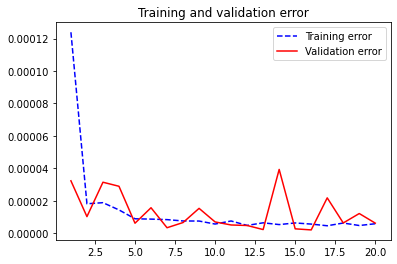

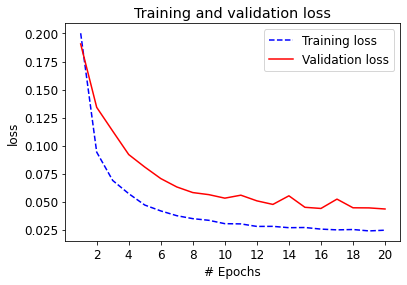

In [9]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '--b', label='Training error')
plt.plot(epochs, val_acc, 'r', label='Validation error')
plt.title('Training and validation error')
plt.legend()
plt.show()

ax = plt.figure()
plt.rc('font', size=12)
plt.plot(epochs, loss, '--b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.locator_params(axis='x', nbins=20)
plt.xlabel('# Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

# Make Predictions

In [10]:
# model = load_model('model_unet_checkpoint.h5', compile=False)
model = load_model('model_unet_checkpoint.h5', compile=False)
model.compile(loss="mean_squared_error", optimizer='adam', metrics=["mean_squared_error"])

preds_test = model.predict(X_test, verbose=1)


3/3 [==============================] - 9s 2s/step


### Prediction test data (unseen)

20


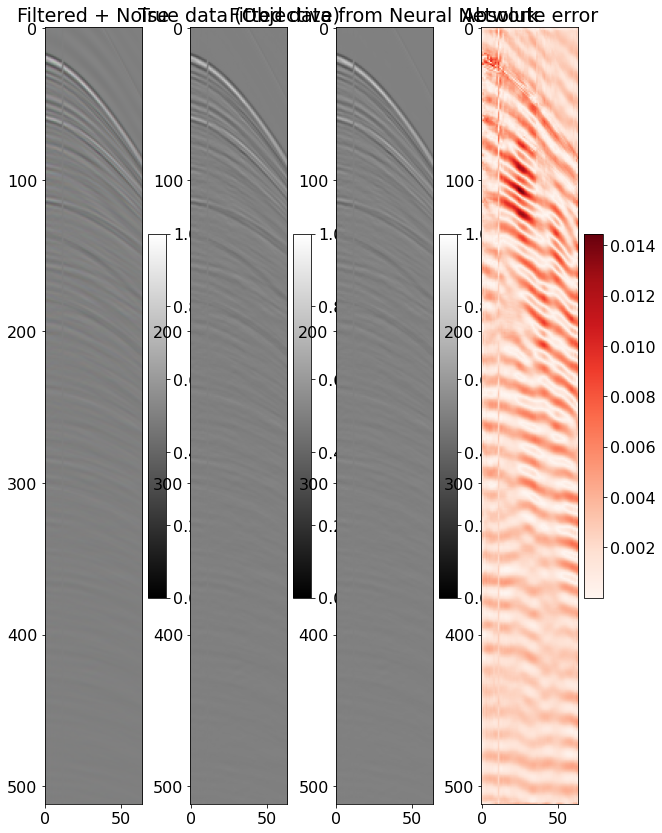

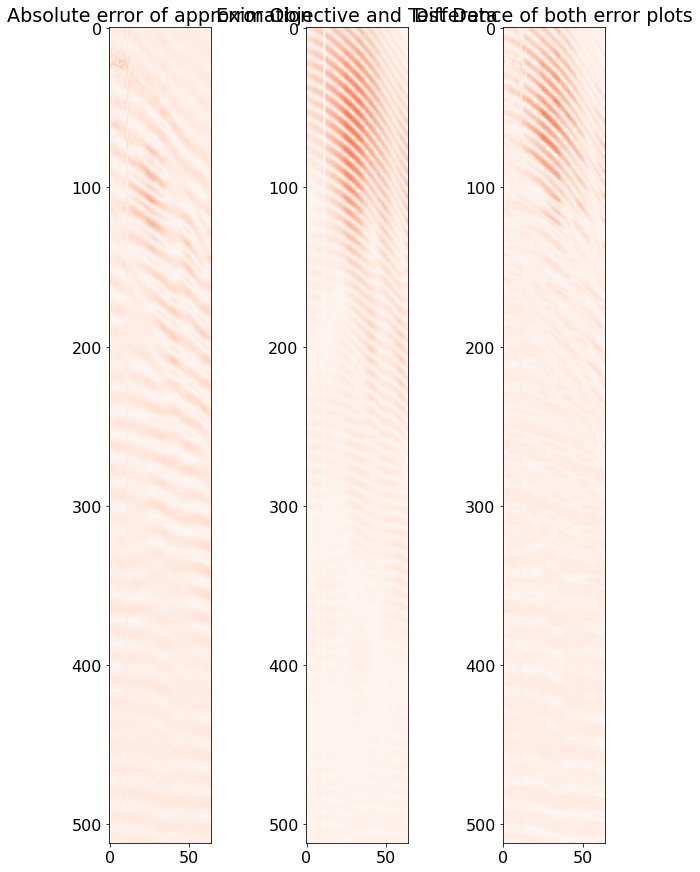

The MAE of the input data was: 1.3811220903623038e-06
The MAE of the ouput data was: 0.0024303148430727724
The max of the input data was: 0.09172066608574325
The max of the ouput data was: 0.008945730011380881


In [17]:
# Perform a sanity check on some random validation samples

ix = random.randint(0, preds_test.shape[0]-1)
# ix = 0
print(ix)

# for ix in range(len(preds_test)):
#     print(ix)
#     print(abs(np.array([Y_test[ix,:,:] - preds_test[ix,:,:]])).max())

f = plt.figure(figsize=(10,15))
ax1 = f.add_subplot(141)
plt.imshow(X_test[ix,:,:], cmap='gray')
plt.colorbar()
plt.title('Filtered + Noise')
plt.clim(0,1)

ax2 = f.add_subplot(142)
plt.imshow(Y_test[ix,:,:], cmap='gray')
plt.title('True data (Objective)')
plt.colorbar()
plt.clim(0,1)

ax3 = f.add_subplot(143)
plt.imshow(preds_test[ix,:,:], cmap='gray')
plt.title('Fitted data from Neural Network')
plt.colorbar()
plt.clim(0,1)

ax4 = f.add_subplot(144)
plt.imshow(abs(Y_test[ix,:,:] - preds_test[ix,:,:]),cmap = 'Reds')
plt.title('Absolute error')
plt.colorbar()
# plt.clim(0,0.05)
plt.show()

f = plt.figure(figsize=(10,15))
ax = f.add_subplot(131)
plt.imshow(abs(Y_test[ix,:,:] - preds_test[ix,:,:]),cmap = 'Reds')
plt.clim(0, 0.05)
plt.title('Absolute error of approximation')


ax = f.add_subplot(132)
plt.imshow(abs(Y_test[ix,:,:].squeeze() - X_test[ix,:,:,1]),cmap = 'Reds')
plt.clim(0, 0.05)
plt.title('Error Objective and Test Data')


ax = f.add_subplot(133)
plt.imshow(abs(abs(Y_test[ix,:,:].squeeze() - np.squeeze(X_test[ix,:,:,1]))-abs(Y_test[ix,:,:].squeeze() - preds_test[ix,:,:].squeeze())),cmap = 'Reds')
plt.title('Difference of both error plots')
plt.clim(0, 0.05)
plt.show()

print('The MAE of the input data was: ' + str(np.abs(np.mean(Y_test[ix,:,:]-X_test[ix,:,:]))))
print('The MAE of the ouput data was: ' + str(np.abs(np.mean(Y_test[ix,:,:]-preds_test[ix,:,:]))))
print('The max of the input data was: ' + str(np.max(Y_test[ix,:,:]-X_test[ix,:,:])))
print('The max of the ouput data was: ' + str(np.max(Y_test[ix,:,:]-preds_test[ix,:,:])))

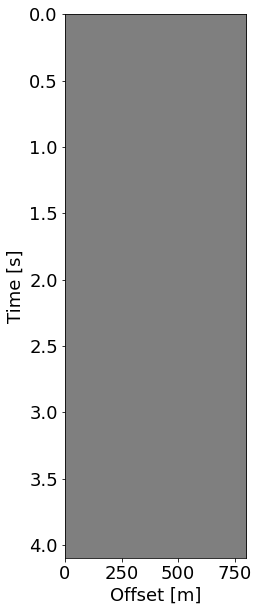

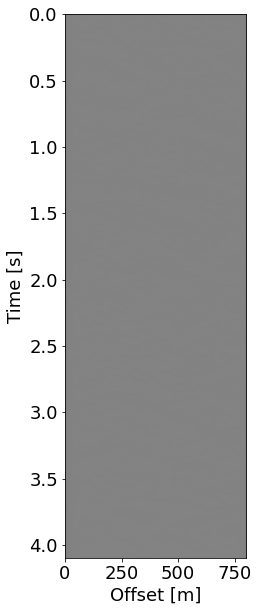

In [12]:
plt.rc('font', size=18)
# ix = random.randint(0, len(preds_test)-1)
#define matplotlib figure and axis
t = np.arange(0,X_test.shape[1]*0.008,0.008)
x = np.arange(0,X_test.shape[2]*12.5,12.5)
fig, ax = plt.subplots(figsize=(15,10))

#create simple line plot
plt.imshow(X_test[ix,:,:],extent=[0,X_test.shape[2]*12.5,X_test.shape[1]*0.008,0], cmap='gray')
plt.clim(0.4, 0.6)
plt.xlabel('Offset [m]')
plt.ylabel('Time [s]')

#set aspect ratio to 1
ratio = 3
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax.set_xticks((0,250,500,750))

#display plot
plt.show()

#define matplotlib figure and axis
fig, ax = plt.subplots(figsize=(15,10))

#create simple line plot
plt.imshow(preds_test[ix,:,:],extent=[0,X_test.shape[2]*12.5,X_test.shape[1]*0.008,0], cmap='gray')
plt.clim(0.4, 0.6)
plt.xlabel('Offset [m]')
plt.ylabel('Time [s]')

#set aspect ratio to 1
ratio = 3
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax.set_xticks((0,250,500,750))

#display plot
plt.show()

In [21]:
X_test.shape

(80, 512, 64, 3)

# Plotting the frequency and phase

Showing window: 40
(80, 512, 64, 1)
(80, 512, 64, 1)
[0. 0. 0. 0.]


C:\Users\samtu\AppData\Local\Temp/ipykernel_6316/510643058.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--g" (-> color='g'). The keyword argument will take precedence.
  plt.plot(x,20*np.log10(f3),'--g',color='#00841a',label='Filtered')


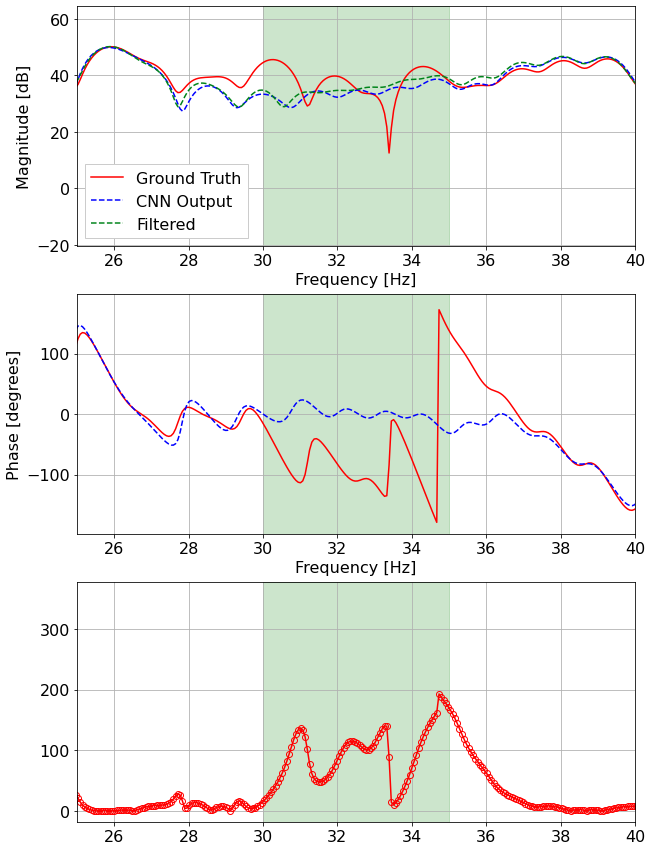

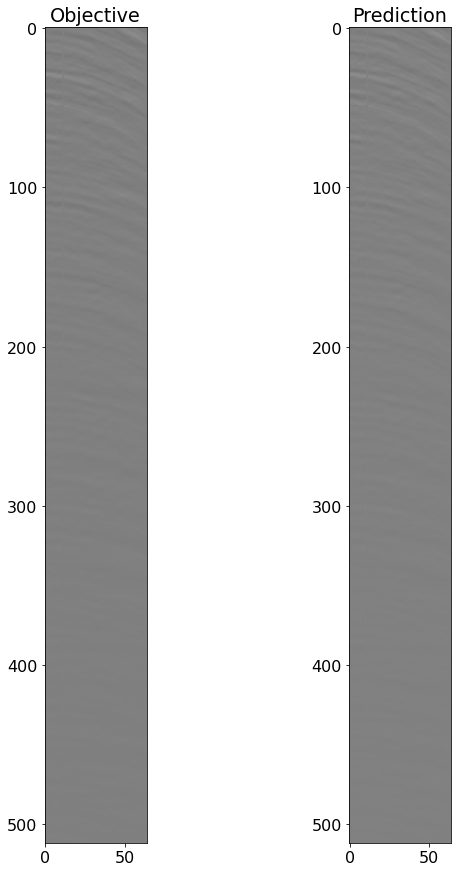

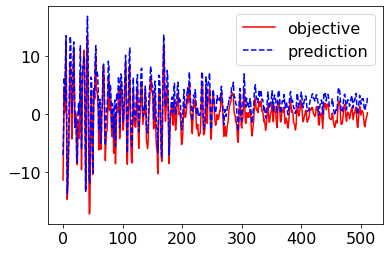

In [56]:
##Frequency Plotting
trace = 30
windownumber = random.randint(0, len(preds_test)-1)
windownumber = 40

nfft = 16*len(Y_test[windownumber,:,trace,:])

print(f'Showing window: {windownumber}')
print(Y_test.shape)
print(preds_test.shape)
print(freqRemoveTest[windownumber,:])

input_gather = ((Y_test[windownumber,:,trace,:].copy()*2)-1)*normfac
filtered = ((X_test[windownumber,:,trace,1].copy()*2)-1)*normfac
out = (((preds_test[windownumber,:,trace,:].copy())*2)-1)*normfac

f1=np.abs(fft(input_gather,axis=0,n=nfft))
f2=np.abs(fft(out,axis=0,n=nfft))
f3=np.abs(fft(filtered,axis=0,n=nfft))

x=np.linspace(0,1/dt,nfft).reshape(nfft,1)

p1 = np.angle(fft(input_gather,axis=0,n=nfft))*180/np.pi
p2 = np.angle(fft(out,axis=0,n=nfft))*180/np.pi
p3 = np.angle(fft(filtered,axis=0,n=nfft))*180/np.pi

# idx = (30<=x) * (x<=35)
# RMS = np.mean(abs(p1[idx]-p2[idx]))
# print(RMS)

#Load Filter boundaries
fig = plt.figure(figsize=(10,15))
fig.add_subplot(3,1,1)
plt.rc('font', size=16)
# plt.axvspan(freqRemoveTest[windownumber,0], freqRemoveTest[windownumber,1], color='green', alpha=0.2)
# plt.axvspan(freqRemoveTest[windownumber,2], freqRemoveTest[windownumber,3], color='red', alpha=0.2)
plt.axvspan(30, 35, color='green', alpha=0.2)
plt.plot(x,20*np.log10(f1),'r',label='Ground Truth')
plt.plot(x,20*np.log10(f2),'--b',label='CNN Output')
plt.plot(x,20*np.log10(f3),'--g',color='#00841a',label='Filtered')
plt.xlim(25,40)
# plt.ylim(140,200)
# plt.ylim(-40,30)
# plt.title('Frequency response');
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.legend(framealpha = 1,fancybox = 0)

fig.add_subplot(3,1,2)
plt.plot(x,p1,'-r',label='Ground Truth', markerfacecolor='None')
plt.plot(x,p2,'--b',label='CNN Output')
# plt.plot(x,p3,'--g',label='Filtered')
plt.axvspan(30, 35, color='green', alpha=0.2)
# plt.axvspan(freqRemoveTest[windownumber,0], freqRemoveTest[windownumber,1], color='green', alpha=0.2)
# plt.axvspan(freqRemoveTest[windownumber,2], freqRemoveTest[windownumber,3], color='red', alpha=0.2)
plt.xlim(25,40)
# plt.ylim(-np.pi,np.pi)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [degrees]')
# plt.legend(framealpha = 1,fancybox = 0)
plt.grid()

fig.add_subplot(3,1,3)
plt.plot(x,np.abs(np.unwrap(np.angle(fft(input_gather,axis=0,n=nfft)))-np.unwrap(np.angle(fft(out,axis=0,n=nfft))))*180/np.pi,'-or',label='Ground Truth', markerfacecolor='None')
plt.axvspan(30, 35, color='green', alpha=0.2)
plt.xlim(25,40)
plt.grid()
plt.show

f = plt.figure(figsize=(10,15))
ax = f.add_subplot(121)
plt.imshow(Y_test[windownumber,:,:,:], cmap='gray')
plt.title('Objective')
plt.clim(0.2,0.8)

ax = f.add_subplot(122)
plt.imshow(preds_test[windownumber,:,:,:], cmap='gray')
plt.title('Prediction')
plt.clim(0.2,0.8)
plt.show()

plt.plot(input_gather,'-r',label='objective')
plt.plot(out,'--b',label='prediction')
# plt.plot(filtered,'.',label='input data')
plt.legend()
plt.show()



Showing window: 40
(80, 512, 64, 1)
(80, 512, 64, 1)
[0. 0. 0. 0.]
56.96286910874053


C:\Users\samtu\AppData\Local\Temp/ipykernel_6316/420898135.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--g" (-> color='g'). The keyword argument will take precedence.
  plt.plot(x,20*np.log10(f3),'--g',color='#00841a',label='Filtered')


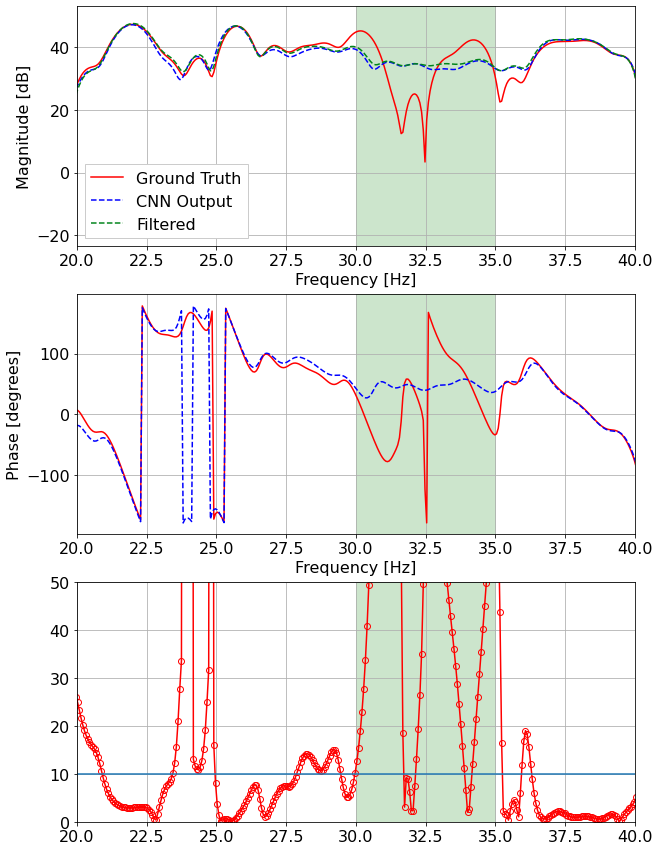

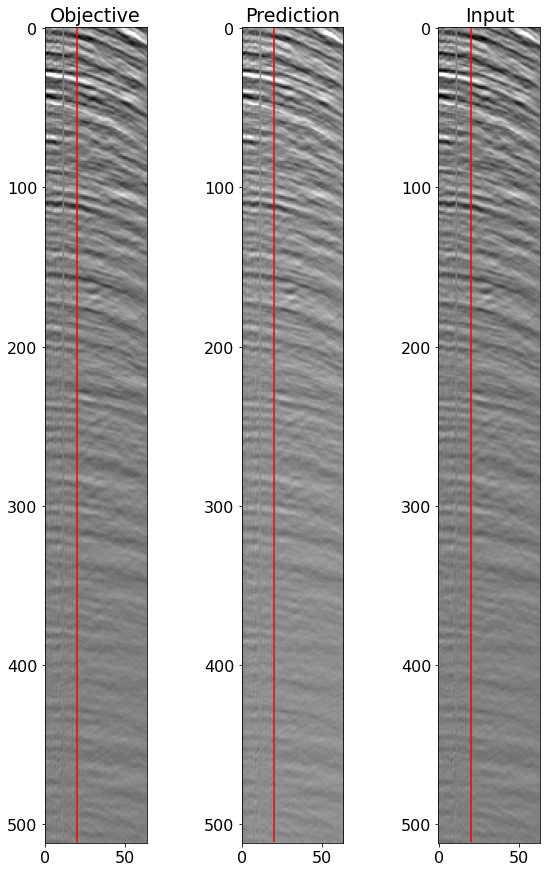

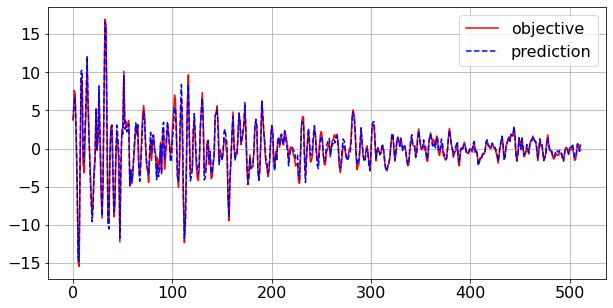

In [55]:
##Frequency Plotting
trace = 20

windownumber = random.randint(0, len(preds_test)-1)
windownumber = 40
nfft = 16*len(Y_test[windownumber,:,trace,:])


print(f'Showing window: {windownumber}')
print(Y_test.shape)
print(preds_test.shape)
print(freqRemoveTest[windownumber,:])

input_gather = ((Y_test[windownumber,:,trace,:].copy()*2)-1)*normfac
filtered = ((X_test[windownumber,:,trace,1].copy()*2)-1)*normfac
out = (((preds_test[windownumber,:,trace,:].copy())*2)-1)*normfac-2

f1=np.abs(fft(input_gather,axis=0,n=nfft))
f2=np.abs(fft(out,axis=0,n=nfft))
f3=np.abs(fft(filtered,axis=0,n=nfft))

x=np.linspace(0,1/dt,nfft).reshape(nfft,1)

p1 = np.angle(fft(input_gather,axis=0,n=nfft))*180/np.pi
p2 = np.angle(fft(out,axis=0,n=nfft))*180/np.pi
p3 = np.angle(fft(filtered,axis=0,n=nfft))*180/np.pi

idx = (30<=x) * (x<=35)
RMS = np.mean(abs(p1[idx]-p2[idx]))
print(RMS)

#Load Filter boundaries
fig = plt.figure(figsize=(10,15))
fig.add_subplot(3,1,1)
plt.rc('font', size=16)
# plt.axvspan(freqRemoveTest[windownumber,0], freqRemoveTest[windownumber,1], color='green', alpha=0.2)
# plt.axvspan(freqRemoveTest[windownumber,2], freqRemoveTest[windownumber,3], color='red', alpha=0.2)
plt.axvspan(30, 35, color='green', alpha=0.2)
plt.plot(x,20*np.log10(f1),'r',label='Ground Truth')
plt.plot(x,20*np.log10(f2),'--b',label='CNN Output')
plt.plot(x,20*np.log10(f3),'--g',color='#00841a',label='Filtered')
plt.xlim(20,40)
# plt.title('Frequency response');
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.legend(framealpha = 1,fancybox = 0)

fig.add_subplot(3,1,2)
plt.plot(x,p1,'-r',label='Ground Truth')#, markerfacecolor='None')
plt.plot(x,p2,'--b',label='CNN Output')
# plt.plot(x,p3,'--g',label='Filtered')
plt.axvspan(30, 35, color='green', alpha=0.2)
# plt.axvspan(freqRemoveTest[windownumber,0], freqRemoveTest[windownumber,1], color='green', alpha=0.2)
# plt.axvspan(freqRemoveTest[windownumber,2], freqRemoveTest[windownumber,3], color='red', alpha=0.2)
plt.xlim(20,40)
# plt.ylim(-np.pi,np.pi)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [degrees]')
# plt.legend(framealpha = 1,fancybox = 0)
plt.grid()


fig.add_subplot(3,1,3)
plt.plot(x,np.abs(np.angle(fft(input_gather,axis=0,n=nfft))-np.angle(fft(out,axis=0,n=nfft)))*180/np.pi,'-or',label='Ground Truth', markerfacecolor='None')
plt.axvspan(30, 35, color='green', alpha=0.2)
plt.hlines(10,0,len(out))
plt.xlim(20,40)
plt.ylim(0,50)
plt.grid()
plt.show

f = plt.figure(figsize=(10,15))
ax = f.add_subplot(131)
plt.imshow(((Y_test[windownumber,:,:,:]*2)-1)*normfac, cmap='gray')
plt.vlines(trace,0,511,'r')
plt.title('Objective')
plt.clim(-20,20)

ax = f.add_subplot(132)
plt.imshow(((preds_test[windownumber,:,:,:]*2)-1)*normfac, cmap='gray')
plt.vlines(trace,0,511,'r')
plt.title('Prediction')
plt.clim(-20,20)

ax = f.add_subplot(133)
plt.imshow(((X_test[windownumber,:,:,1]*2)-1)*normfac, cmap='gray')
plt.vlines(trace,0,511,'r')
plt.title('Input')
plt.clim(-20,20)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(input_gather,'-r',label='objective')
plt.plot(out,'--b',label='prediction')
# plt.ylim(-50,50)
# plt.plot(filtered,'.',label='input data')
plt.legend()
plt.grid()
plt.show()


## RMS Calculation

<function matplotlib.pyplot.show(close=None, block=None)>

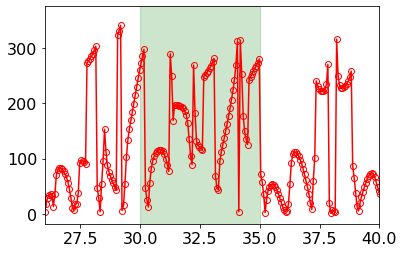

In [15]:
# abs(np.angle(fft(preds_test, axis=0)) - Y_test)
plt.plot(x,abs(np.unwrap(p1)-np.unwrap(p2)),'-or',label='Ground Truth', markerfacecolor='None')
plt.axvspan(30, 35, color='green', alpha=0.2)
plt.xlim(26,40)
plt.show